# Evaluación de resultados de un algoritmo de Regresion Logistica con scikit Learning

En este notebook se muestran técnicas para la evaluación de los resultados de una predicción con un algoritmo de Regresion Logistica

## Conjunto de datos

### Descripción
NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods. Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

### Ficheros de datos
* <span style="color:green">**KDDTrain+.ARFF**: The full NSL-KDD train set with binary labels in ARFF format</span>
* KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF:	A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT:	A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF:	The full NSL-KDD test set with binary labels in ARFF format
* KDDTest+.TXT:	The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF:	A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT:	A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

### Descarga de los ficheros de datos
https://iscxdownloads.cs.unb.ca/iscxdownloads/NSL-KDD/#NSL-KDD

### Referencias adicionales sobre el conjunto de datos
_M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009._

## Imports

In [8]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares

In [15]:
def load_kdd_dataset(data_path):
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset['attributes']]
    return pd.DataFrame(dataset['data'], columns=attributes)

In [10]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(df, test_size=0.4, random_state=rstate, shuffle = shuffle , stratify = strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return train_set, val_set, test_set

In [11]:
# COnstruccion de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

In [65]:
# Transformador para codificar unicamnete las columnas categoricas y devolver el df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder()
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        print(X_cat_oh)
        X_cat_oh = pd.DataFrame(X_cat_oh.toarray(), columns=self._columns, index=X_copy.index)
        X_copy.drop(list(X_cat), axis = 1, inplace=True)
        return X_copy.join(X_cat_oh)

In [62]:
# Contruccion que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
            ('num', num_pipeline, num_attribs),
            ('cat', CustomOneHotEncoder(), cat_attribs)
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, columns=self._columns, index=X_copy.index)

## Lectura del conjunto de datos

In [16]:
df = load_kdd_dataset(r"C:\Users\crisb\Documents\Curso Data Science Udemy\datasets\NSL-KDD\KDDTrain+.arff")


In [17]:
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## División del conjunto de datos

In [18]:
# Division del conjunto en los distintos subconjuntos
train_set, val_set, test_set = train_val_test_split(df, stratify='class')

In [19]:
print("Longitud del conjunto de entrenamiento: ", len(train_set))
print("Longitud del conjunto de validación: ", len(val_set))
print("longitud del conjunto de test: ", len(test_set))

Longitud del conjunto de entrenamiento:  75583
Longitud del conjunto de validación:  25195
longitud del conjunto de test:  25195


Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [20]:
# Conjunto de datos general
X_df = df.drop("class", axis=1)
y_df = df["class"].copy()

In [21]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

In [22]:
# Conjunto de datos de validación
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()

In [23]:
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

## Preparación del conjunto de datos

In [63]:
# Instanciamos el primer transformador personalizado
data_preparer = DataFramePreparer()

In [64]:
data_preparer.fit(X_df)

DataFramePreparer()

In [66]:
X_train_prep = data_preparer.transform(X_train)

In [67]:
X_train_prep.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
79609,1.0,2.938406,0.633721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
79887,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
108746,0.0,-0.003623,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
57514,0.0,0.637681,0.571705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
50720,0.0,0.721014,20.738372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [68]:
# Transformamos el subconjunto de datos de validacion
X_val_prep = data_preparer.transform(X_val)

## Entrenamiento de un algoritmo de Regresión Logística

La instanciación de un algoritmo de Machine Learning utilizando Sklearn se realiza utilizando los métodos expuestos por la API de sklearnm en este caso con 1000 iteraciones

In [69]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, solver='newton-cg')
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

## Predicción de nuevos ejemplos

Realizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de Regresión Logística. Utilizamos el subconjunto de validación.

In [70]:
y_pred = clf.predict(X_val_prep)

## 1. Matriz de Confusión

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[11333,   393],
       [  226, 13243]], dtype=int64)

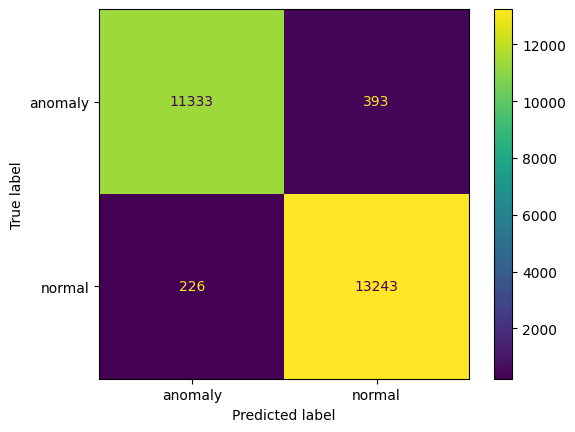

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_val_prep, y_val, values_format='d')

## 2. Métricas derivadas de la matriz de confusión

### Precisión

In [73]:
from sklearn.metrics import precision_score
print("Precision: ", precision_score(y_val, y_pred, pos_label='anomaly'))

Precision:  0.980448135651873


### Recall

In [74]:
from  sklearn.metrics import recall_score
print("Recall: ", recall_score(y_val, y_pred, pos_label='anomaly'))

Recall:  0.9664847347774177


### F1 Score

In [75]:
from sklearn.metrics import f1_score
print("F1 Score: ", f1_score(y_val, y_pred, pos_label='anomaly'))

F1 Score:  0.9734163624651063


## 3. Curvas ROC y PR

### Curva ROC

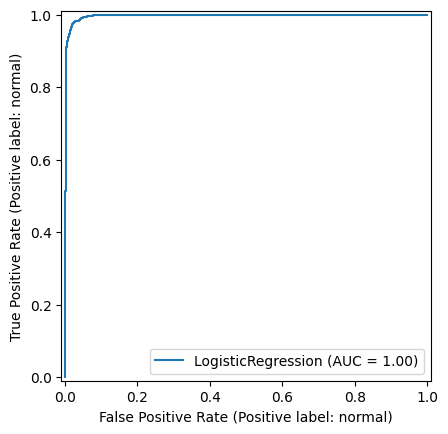

In [76]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)

### Curva PR

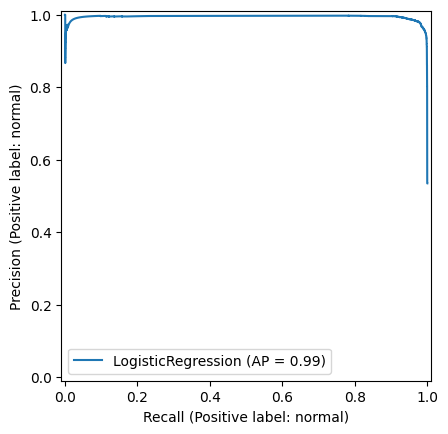

In [77]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val)

## 4. Evaluación del modelo con el conjunto de datos de pruebas

In [78]:
# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)

In [79]:
y_pred_prep = data_preparer.transform(X_test)

In [80]:
y_pred = clf.predict(X_test_prep)

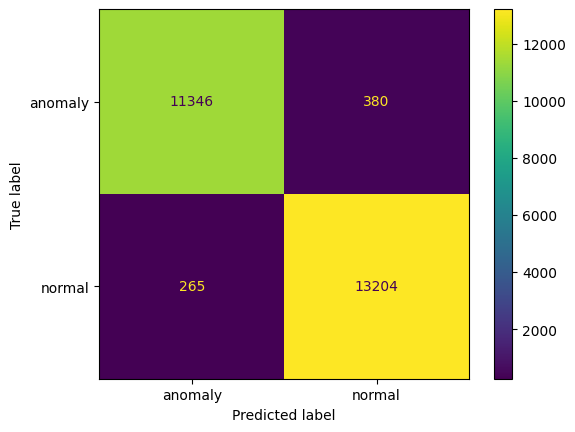

In [81]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_prep, y_test, values_format='d')

In [82]:
print('F1 score:', f1_score(y_test, y_pred, pos_label='anomaly'))

F1 score: 0.9723614860521917
